# This notebook is the result my answering [this question on Stack Overflow](http://stackoverflow.com/questions/26872337/how-can-i-get-my-contour-plot-superimposed-on-a-basemap/26885815#26885815), by way of teaching myself about contour plots and interpolating point data

In [1]:
import numpy as np
import pandas as pd
from matplotlib.mlab import griddata
from mpl_toolkits.basemap import Basemap, interp
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, MultiPolygon, box
from descartes import PolygonPatch
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['savefig.dpi'] = 200
import math
from itertools import chain

Only run the cell below if you have LaTeX installed

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

### These are helper functions for more flexible Voronoi plotting

In [17]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    from http://stackoverflow.com/a/20678647/416626
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


def plot_voronoi(lon, lat, ax, **kwargs):
    """ 
    More flexible Voronoi plotting
    kwargs are passed to ax.plot()
    returns computed voronoi object
    This is a bit of a black box tbh
    adapted from http://nbviewer.ipython.org/gist/wiso/6755034
    """
    vor = Voronoi(data[['projected_lon', 'projected_lat']])
    xy = np.dstack((lon, lat))[0]
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], **kwargs)
    center = xy.mean(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0]
            t = xy[pointidx[1]] - xy[pointidx[0]]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = xy[pointidx].mean(axis=0)
            far_point = vor.vertices[i] + \
            np.sign(np.dot(midpoint - center, n)) * n * 10000000
            vor.complete_regions, vor.complete_vertices = voronoi_finite_polygons_2d(vor)
            #  this plots the far points - maybe consider a dashed line
            ax.plot(
                [vor.vertices[i, 0], far_point[0]],
                [vor.vertices[i, 1], far_point[1]],
                **kwargs)
    return vor

This is a dict of lon / lat points (assumed to be WGS84) and associated mean rainfall measurements.

In [3]:
dd = {"Lon": {0: 32.600000000000001,
  1: 27.100000000000001,
  2: 32.700000000000003,
  3: 24.199999999999999,
  4: 28.5,
  5: 28.100000000000001,
  6: 27.899999999999999,
  7: 24.800000000000001,
  8: 31.100000000000001,
  9: 25.899999999999999,
  10: 29.100000000000001,
  11: 25.800000000000001,
  12: 33.200000000000003,
  13: 28.300000000000001,
  14: 27.600000000000001,
  15: 28.899999999999999,
  16: 31.300000000000001,
  17: 31.899999999999999,
  18: 23.100000000000001,
  19: 31.399999999999999,
  20: 27.100000000000001,
  21: 24.399999999999999,
  22: 28.600000000000001,
  23: 31.300000000000001,
  24: 23.300000000000001,
  25: 30.199999999999999,
  26: 24.300000000000001,
  27: 26.399999999999999,
  28: 23.100000000000001},
 "Lat": {0: -13.6,
  1: -16.899999999999999,
  2: -10.199999999999999,
  3: -13.6,
  4: -14.4,
  5: -12.6,
  6: -15.800000000000001,
  7: -14.800000000000001,
  8: -10.199999999999999,
  9: -13.5,
  10: -9.8000000000000007,
  11: -17.800000000000001,
  12: -12.300000000000001,
  13: -15.4,
  14: -16.100000000000001,
  15: -11.1,
  16: -8.9000000000000004,
  17: -13.300000000000001,
  18: -15.300000000000001,
  19: -11.9,
  20: -15.0,
  21: -11.800000000000001,
  22: -13.0,
  23: -14.300000000000001,
  24: -16.100000000000001,
  25: -13.199999999999999,
  26: -17.5,
  27: -12.199999999999999,
  28: -13.5},
 "m1": {0: 41,
  1: 43,
  2: 46,
  3: 33,
  4: 43,
  5: 33,
  6: 46,
  7: 44,
  8: 35,
  9: 24,
  10: 10,
  11: 39,
  12: 44,
  13: 46,
  14: 47,
  15: 31,
  16: 39,
  17: 45,
  18: 31,
  19: 39,
  20: 42,
  21: 15,
  22: 39,
  23: 44,
  24: 39,
  25: 38,
  26: 32,
  27: 23,
  28: 27},
 "m2": {0: 9,
    1: 12,
    2: 14,
    3: 13,
    4: 11,
    5: 16,
    6: 13,
    7: 9,
    8: 14,
    9: 8,
    10: 13,
    11: 11,
    12: 8,
    13: 12,
    14: 9,
    15: 15,
    16: 9,
    17: 9,
    18: 9,
    19: 9,
    20: 12,
    21: 9,
    22: 9,
    23: 12,
    24: 5,
    25: 11,
    26: 10,
    27: 12,
    28: 14,
    }}

In [4]:
# uncomment to get from CSV
# data = pd.read_csv(
#     'means.tsv',
#     delim_whitespace=True, header=None,
#     names=["Lon", "Lat", "Z"])
data = pd.DataFrame(dd)
data.head()

,Lat,Lon,m1,m2
0,-13.6,32.6,41,9
1,-16.9,27.1,43,12
2,-10.2,32.7,46,14
3,-13.6,24.2,33,13
4,-14.4,28.5,43,11


## Define a Map Extent, and Set Up a Basemap Instance

In [5]:
# define map extent
lllon = 21
lllat = -18
urlon = 34
urlat = -8

# set up Basemap instance
m = Basemap(
    projection = 'merc',
    llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
    resolution='h')

## Transform Lon / Lat Coordinates to Map Projection Coordinates

In [6]:
# transform lon / lat coordinates to map projection
data['projected_lon'], data['projected_lat'] = m(*(data["Lon"].values, data["Lat"].values))
# instantiate a Normalize() instance for easy scaling of e.g. point sizes
norm = Normalize()

Specify `Z` value as either the first or second set of measurements (`m1` or `m2`)

In [7]:
data['Z'] = data.m1
# data['Z'] = data.m2
data.head()

,Lat,Lon,m1,m2,projected_lon,projected_lat,Z
0,-13.6,32.6,41,9,1289860.541702,508613.423903,41
1,-16.9,27.1,43,12,678288.733137,128217.299455,43
2,-10.2,32.7,46,14,1300980.029131,895041.133113,46
3,-13.6,24.2,33,13,355823.597711,508613.423903,33
4,-14.4,28.5,43,11,833961.557135,416933.424216,43


## Generating a Continuous Surface of the Measurements using Interpolation

### Using `griddata` and Delaunay Natural Neighbour with a 1000-Point Grid

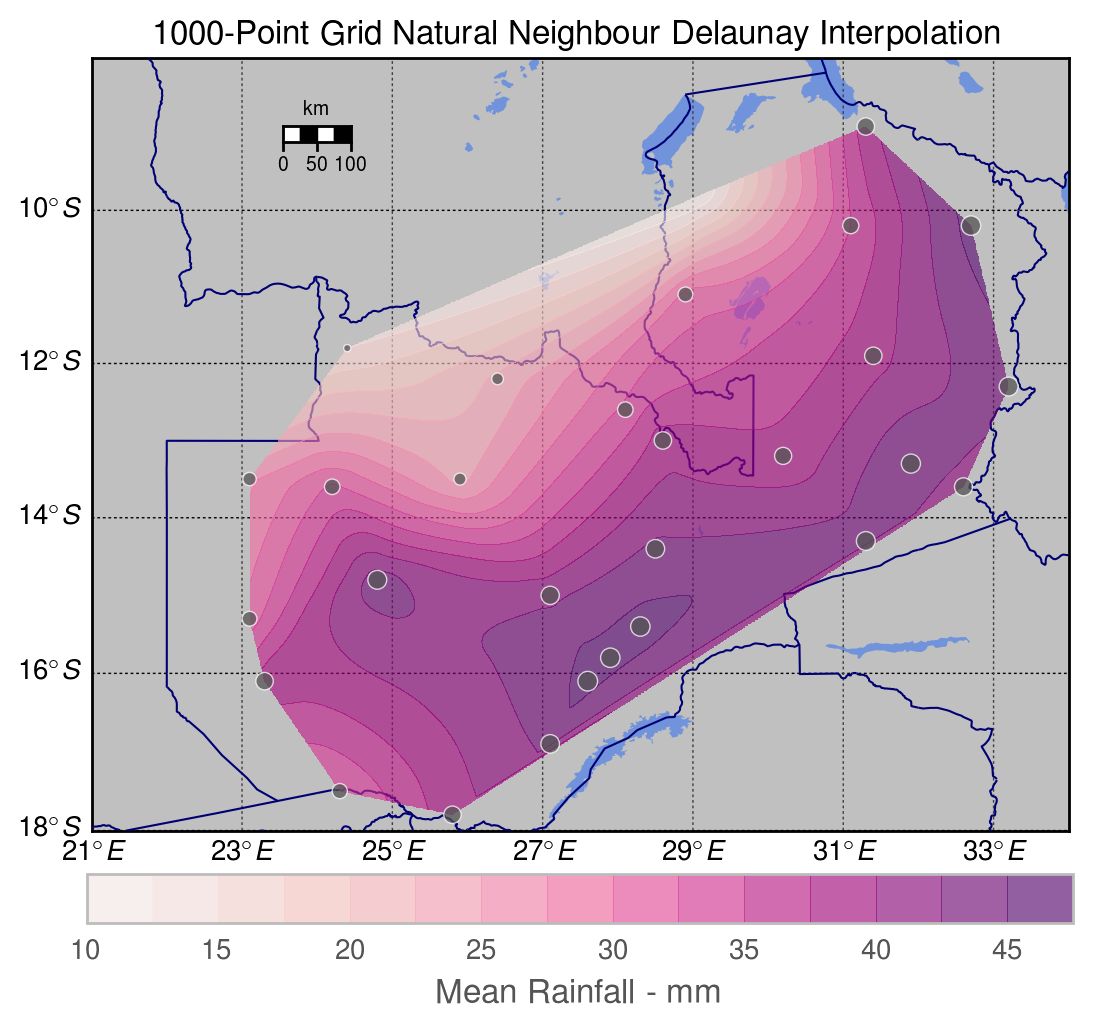

In [9]:
# set up a square grid with the same extents as our measured data
numcols, numrows = 1000, 1000
xi = np.linspace(data['projected_lon'].min(), data['projected_lon'].max(), numcols)
yi = np.linspace(data['projected_lat'].min(), data['projected_lat'].max(), numrows)
# get lon and lat coords of our grid points
xi, yi = np.meshgrid(xi, yi)
# interpolate
x, y, z = data['projected_lon'].values, data['projected_lat'].values, data['Z'].values
zi = griddata(x, y, z, xi, yi)

# set up plot
plt.clf()
fig = plt.figure(figsize=(7.28, 5.25))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

# contour plots
# con = m.contour(xi, yi, zi, 15, zorder=4, linewidths=.25, linestyles='dashed', colors='k', alpha=0.6, ax=ax)
conf = m.contourf(xi, yi, zi, 15, zorder=4, alpha=0.6, cmap='RdPu', ax=ax)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.75,
    s=50 * norm(data['Z']),
    cmap='RdPu',
    ax=ax,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

# add colour bar, title, and scale
cbar = plt.colorbar(conf, orientation='horizontal', fraction=.057, pad=0.05)
cbar.set_label("Mean Rainfall - mm")

plt.title(
    "%s-Point Grid Natural Neighbour Delaunay Interpolation" % numcols,
    fontsize=12)
m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000',
    zorder=5, ax=ax)

plt.tight_layout()
plt.savefig("rainfall_griddata.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Tri-Contouring Using a Coarse Delaunay Mesh

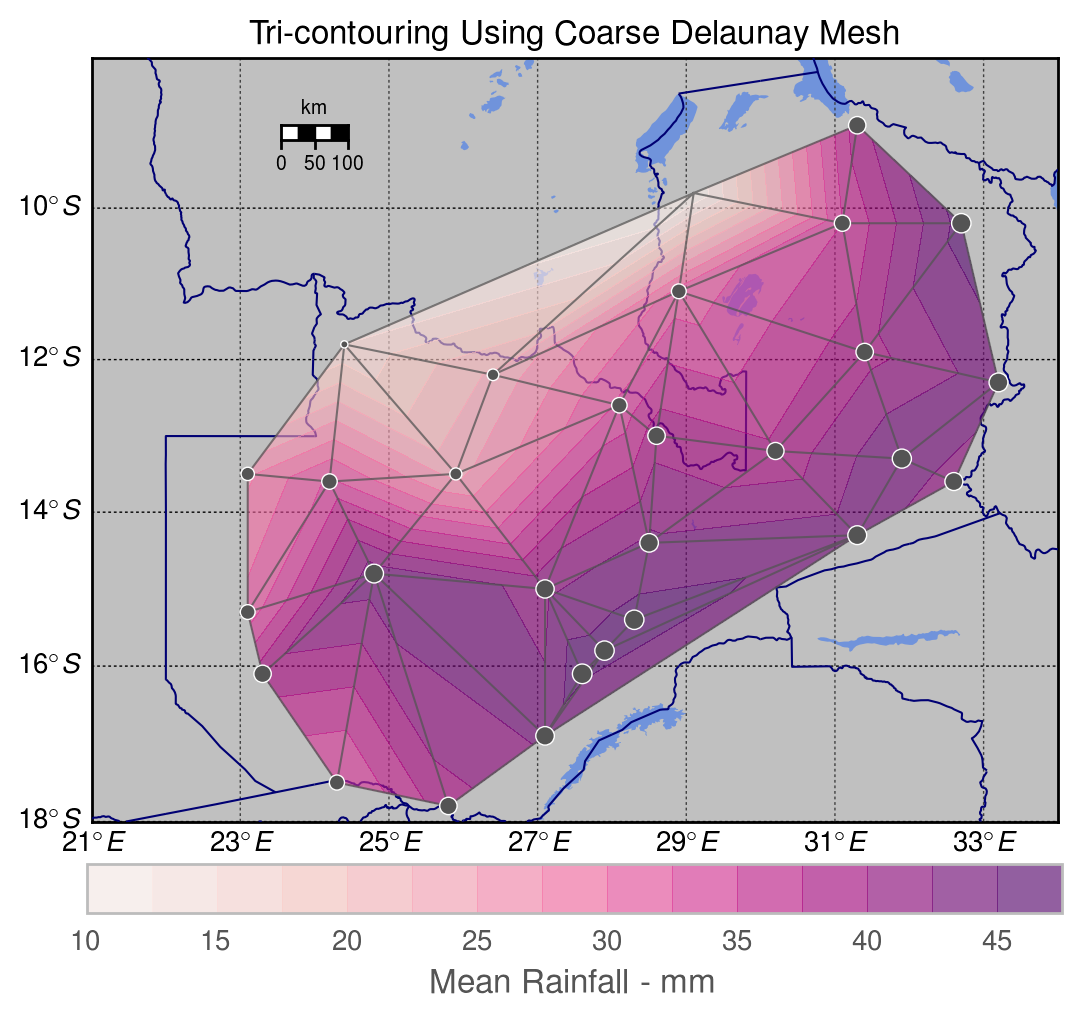

In [11]:
plt.clf()
fig = plt.figure(figsize=(7.22, 5.25))

ax2 = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax2)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax2)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax2, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax2)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax2)

# initial params
subdiv = 5
init_mask_frac = 0.0
min_circle_ratio = .01  
random_gen = np.random.mtrand.RandomState(seed=127260)

# meshing with Delaunay triangulation
tri = Triangulation(data.projected_lon, data.projected_lat)
ntri = tri.triangles.shape[0]

# Some invalid data are masked out
mask_init = np.zeros(ntri, dtype=np.bool)
masked_tri = random_gen.randint(0, ntri, int(ntri*init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)

# improve triangulation
# masking badly shaped triangles at the border of the triangular mesh.
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# plot of the initial coarse mesh
plt.triplot(tri, color='#545454', zorder=4, lw=.75, alpha=.75)

# plot tri-contour
triconf = plt.tricontourf(
    tri, data.Z, 15,
    cmap='RdPu',
    zorder=4, alpha=.6)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=1.,
    s=50 * norm(data['Z']),
    cmap='RdPu',
    ax=ax2,
    vmin=zi.min(), vmax=zi.max(), zorder=5)    
plt.title(
    "Tri-contouring Using Coarse Delaunay Mesh",
    fontsize=12)

cbar = plt.colorbar(
    triconf, orientation='horizontal',
    fraction=.057, pad=0.05, ax=ax2)
cbar.set_label("Mean Rainfall - mm", alpha=1.)

m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000',
    zorder=5, ax=ax2)

plt.tight_layout(pad=1.25)
plt.savefig("rainfall_coarse.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Refining a Coarse Delaunay Mesh Using Recursive Subdivision and Cubic Interpolation

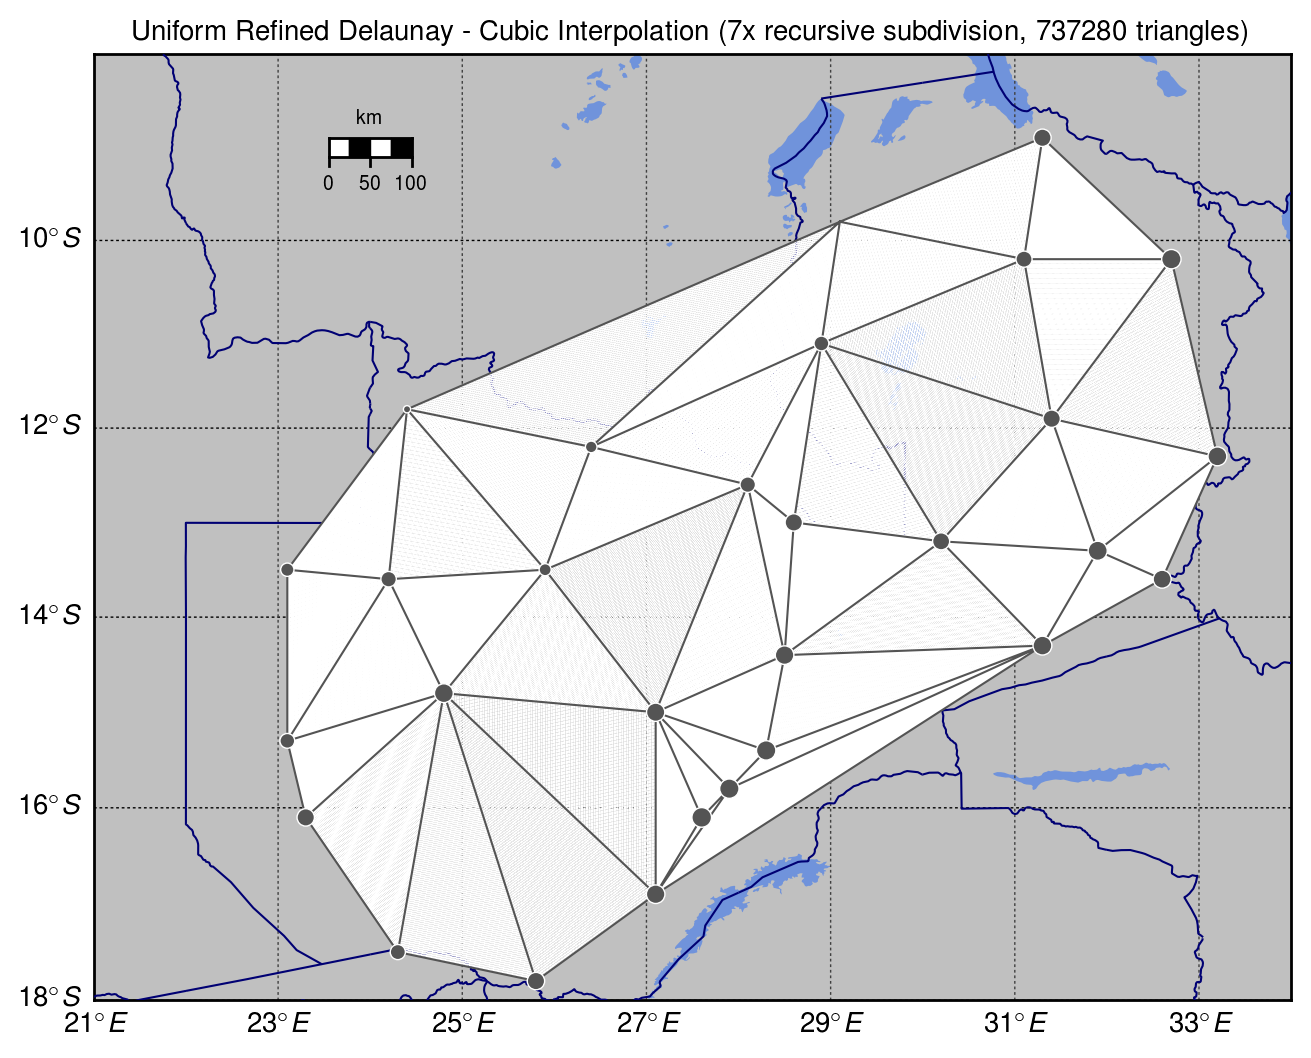

In [14]:
# set up plot
# numrows, numcolumns, plot number
# 211, 212 BUT 111, 211 is better
plt.clf()
fig = plt.figure(figsize=(7.22, 5.25))

ax2 = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax2)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax2)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax2, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax2)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax2)

#######
# initial params

# the recommended value for recursion is 3
# we can go higher because we only have 29 points
subdiv = 7
init_mask_frac = 0.0
min_circle_ratio = .01  
random_gen = np.random.mtrand.RandomState(seed=127260)

# meshing with Delaunay triangulation
tri = Triangulation(data.projected_lon, data.projected_lat)
ntri = tri.triangles.shape[0]

# Some invalid data are masked out
mask_init = np.zeros(ntri, dtype=np.bool)
masked_tri = random_gen.randint(0, ntri, int(ntri*init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)

# improve triangulation
# masking badly shaped triangles at the border of the triangular mesh.
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# refining the data
refiner = UniformTriRefiner(tri)
tri_refi, z_test_refi = refiner.refine_field(data.Z, subdiv=subdiv)

# 3) plot of the fine mesh on which interpolation was done
plt.triplot(tri_refi, color='#ffffff', zorder=3, lw=.125)

# 4) plot of the initial 'coarse' mesh:
plt.triplot(tri, color='#545454', zorder=4, lw=.75, alpha=1.)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=1.,
    s=50 * norm(data['Z']),
    cmap='RdPu',
    ax=ax2,
    vmin=zi.min(), vmax=zi.max(), zorder=5)    

plt.title(
    "Uniform Refined Delaunay - Cubic Interpolation (%sx recursive subdivision, %s triangles)" %
    (subdiv, tri_refi.triangles.shape[0]),
    fontsize=10)

m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000',
    zorder=5, ax=ax2)

plt.tight_layout(pad=1.25)
plt.savefig("rainfall_refined_mesh.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Comparison of Natural Neighbour and Recursive Cubic Interpolations

/usr/local/lib/python2.7/site-packages/matplotlib-1.4.x-py2.7-macosx-10.8-x86_64.egg/matplotlib/contour.py:930: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


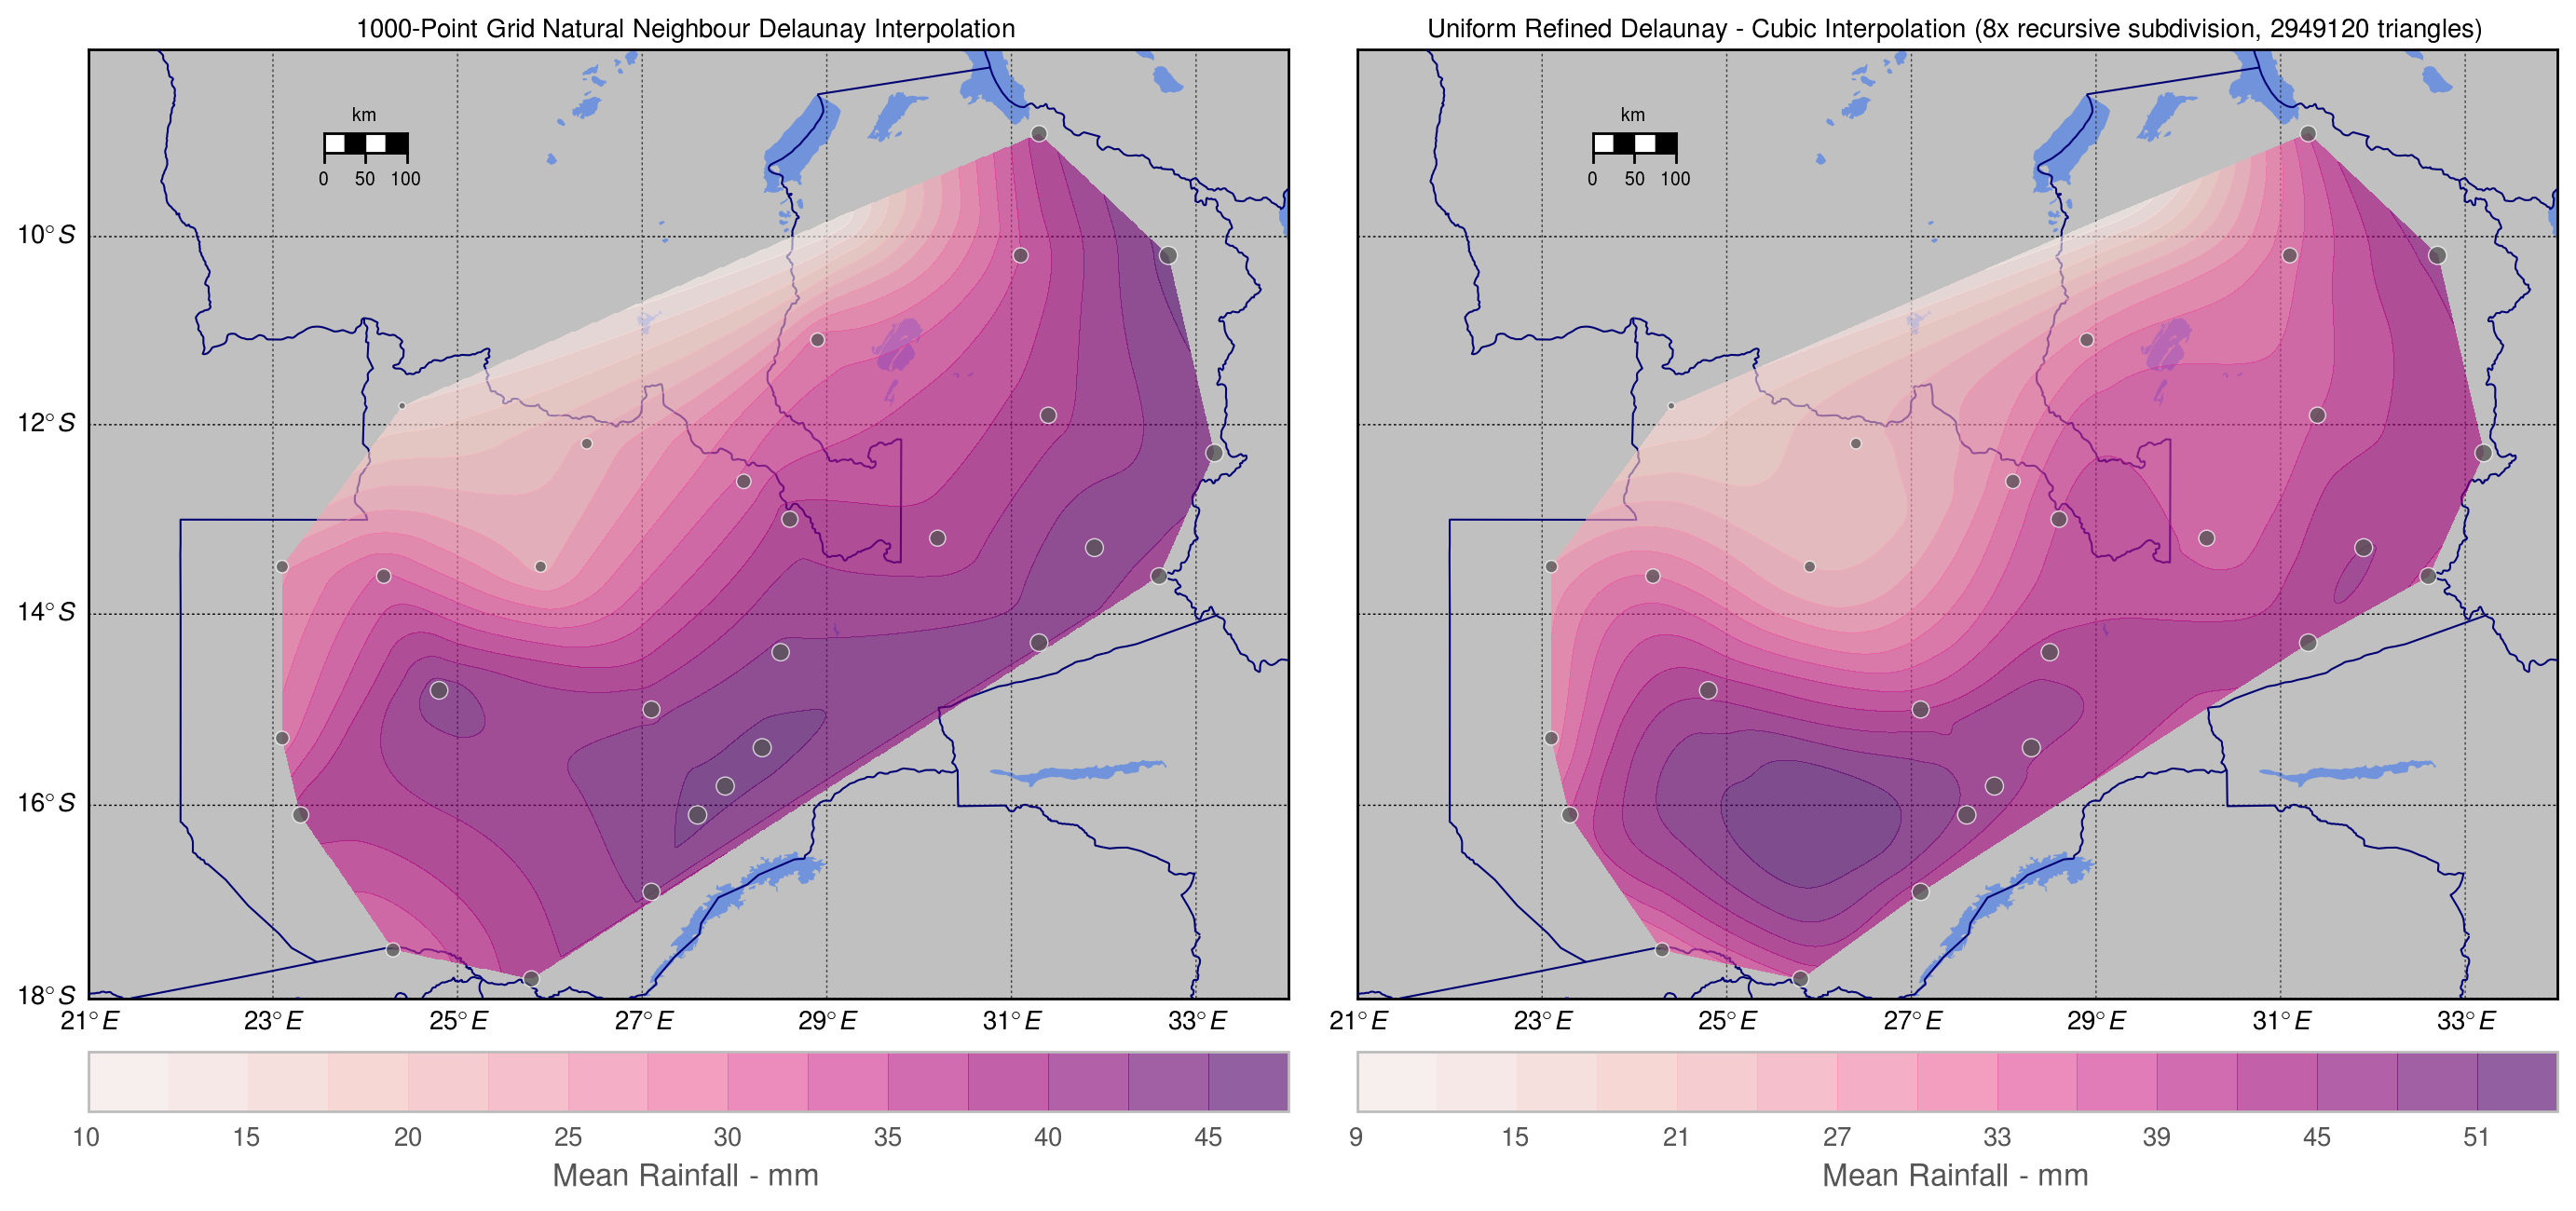

In [15]:
# set up plot
# numrows, numcolumns, plot number
# 211, 212 BUT 111, 211 is better
plt.clf()
fig = plt.figure(figsize=(14, 6.4))
ax = fig.add_subplot(121, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

# contour plots
conf = m.contourf(xi, yi, zi, 15, zorder=4, alpha=0.6, cmap='RdPu', ax=ax)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.75,
    s=50 * norm(data['Z']),
    cmap='RdPu',
    ax=ax,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

# add colour bar, title, and scale
cbar = plt.colorbar(conf, orientation='horizontal', fraction=.057, pad=0.05)
cbar.set_label("Mean Rainfall - mm")

plt.title(
    "%s-Point Grid Natural Neighbour Delaunay Interpolation" % numcols,
    fontsize=10)
m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000',
    zorder=5, ax=ax)


####### LOWER PLOT
ax2 = fig.add_subplot(122, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax2)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax2)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax2, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, False], ax=ax2)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax2)

#######
# initial params
subdiv = 8
init_mask_frac = 0.0
min_circle_ratio = .01  
random_gen = np.random.mtrand.RandomState(seed=127260)

# meshing with Delaunay triangulation
tri = Triangulation(data.projected_lon, data.projected_lat)
ntri = tri.triangles.shape[0]

# Some invalid data are masked out
mask_init = np.zeros(ntri, dtype=np.bool)
masked_tri = random_gen.randint(0, ntri, int(ntri*init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)

# improve triangulation
# masking badly shaped triangles at the border of the triangular mesh.
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# refining the data
refiner = UniformTriRefiner(tri)
tri_refi, z_test_refi = refiner.refine_field(data.Z, subdiv=subdiv)

# Graphical options for tricontouring
levels = np.arange(0., 1., 0.025)
cmap = cm.get_cmap(name='RdPu', lut=None)


# 1) plot of the refined (computed) data countours:
# plt.tricontour(
#     tri_refi, z_test_refi, 15,
#     colors='k',
#     linewidths=.25,
#     linestyles='dashed',
#     zorder=4, alpha=.6)
triconf = plt.tricontourf(
    tri_refi, z_test_refi, 15,
    cmap=cmap,linewidths=[2.0, 0.5, 1.0, 0.5],
    zorder=4, alpha=.6)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.75,
    s=50 * norm(data['Z']),
    cmap='RdPu',
    ax=ax2,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

# add colour bar, title, and scale
cbar2 = plt.colorbar(triconf, orientation='horizontal', fraction=.057, pad=0.05, ax=ax2)
cbar2.set_label("Mean Rainfall - mm", alpha=1.)
    
plt.title(
    "Uniform Refined Delaunay - Cubic Interpolation (%sx recursive subdivision, %s triangles)" %
    (subdiv, tri_refi.triangles.shape[0]),
    fontsize=10)
m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000',
    zorder=5, ax=ax2)

plt.tight_layout(w_pad=.0001)
plt.savefig("rainfall_comparison.png", format="png", transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# Compute Voronoi Cells

In [ ]:
plt.clf()
fig = plt.figure(figsize=(7.22, 5.25))

ax2 = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw map details
m.drawmapboundary(fill_color = 'white', ax=ax2)
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB', ax=ax2)
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax2, zorder=3)

m.drawparallels(
    np.arange(lllat, urlat, 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax2)
m.drawmeridians(
    np.arange(lllon, urlon, 2.),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax2)

# generate voronoi decomposition
vor = Voronoi(data[['projected_lon', 'projected_lat']])
# get finite cells
vor.complete_regions, vor.complete_vertices = voronoi_finite_polygons_2d(vor)
# create square polygon of map extent
clip = box(*(chain(m(lllon, lllat), m(urlon, urlat))))
# clip Voronoi cells to map extent by intersecting with box
clipped = [clip.intersection(poly) for poly in
           (Polygon(pol) for pol in (vor.complete_vertices[region] for region in vor.complete_regions))]
# create patches
patches = (PolygonPatch(pol) for pol in clipped)
# we can specify a normalize instance (area?) and a colour map here
cmap = plt.get_cmap('RdPu')
norm2 = Normalize()
pc = PatchCollection(patches, match_original=False, alpha=0.75, color='#7F00FF', lw=1., zorder=5)
pc.set_facecolor(cmap(norm2(np.array([pol.area for pol in clipped]))))
# uncomment to add the filled voronoi tesselation
ax2.add_collection(pc)

# plot Voronoi cell points
m.scatter(
    *zip(*(chain(*((polygon.exterior.coords) for polygon in clipped)))),
    color='#7F00FF', edgecolor='#ffffff',
    zorder=5, s=10)

# plt.triplot(tri, color='#545454', zorder=5, lw=.75, alpha=.5)

# scatter plot - vmin/max for colormap compat
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=1.,
    s=25,
    cmap='RdPu',
    ax=ax2,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

plt.title(
    "Voronoi Tesselation, Larger Cells are Darker",
    fontsize=10)

m.drawmapscale(
    24., -9., 28., -13,
    100,
    units='km', fontsize=7,
    yoffset=None,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#555555',
    zorder=5, ax=ax2)

plt.tight_layout()
plt.savefig("voronoi.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()